In [1]:
# Data commands:
# `python comet_download.py --project=feature-recycling-large-init-step-size --n_threads=8`

In [2]:
import re
import sys

sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm

from IPython.display import display

from plotting_utils import *

sns.set_theme('notebook', 'white')
%matplotlib inline

In [3]:
save_path = 'figures/'
config_data_path = 'data/feature-recycling-large-init-step-size_params.csv'
run_data_path = f'data/feature-recycling-large-init-step-size_metrics.csv'

all_sweeps_config_df = pd.read_csv(config_data_path, index_col=0)
all_sweeps_run_df = pd.read_csv(run_data_path, index_col=0)

# Remove duplicate config rows, ignoring run_id column
all_sweeps_config_df = all_sweeps_config_df.drop_duplicates(
    subset = [col for col in all_sweeps_config_df.columns if col != 'run_id'],
    keep = 'last',
)
valid_run_ids = set(all_sweeps_config_df['run_id'].unique())
all_sweeps_run_df = all_sweeps_run_df[all_sweeps_run_df['run_id'].isin(valid_run_ids)]
all_sweeps_run_df = all_sweeps_run_df.dropna(subset=['step'])

sweep_names = list(all_sweeps_config_df['sweep_name'].unique())

# Split up dfs by sweep name
run_dfs = {}
config_dfs = {}
for sweep_name in sweep_names:
    config_dfs[sweep_name] = all_sweeps_config_df[all_sweeps_config_df['sweep_name'] == sweep_name].reset_index(drop=True)
    # Drop experiments that did not complete
    max_step = config_dfs[sweep_name]['curr_step'].max()
    config_dfs[sweep_name] = config_dfs[sweep_name][config_dfs[sweep_name]['curr_step'] == max_step]
    
    run_ids = set(config_dfs[sweep_name]['run_id'].unique())
    run_dfs[sweep_name] = all_sweeps_run_df[all_sweeps_run_df['run_id'].isin(run_ids)].reset_index(drop=True)

# # Add in an extra baseline df
# config_dfs['baseline'] = config_dfs['distractor_chance'][config_dfs['distractor_chance']['task|distractor_chance'] == 0]
# vanilla_run_ids = set(config_dfs['baseline']['run_id'].unique())
# run_dfs['baseline'] = run_dfs['distractor_chance'][run_dfs['distractor_chance']['run_id'].isin(vanilla_run_ids)]

In [4]:
{k: len(v) for k, v in config_dfs.items()}

{'target_noise': 93}

In [5]:
def plot_learning_curves_grid(
        run_df,
        config_df,
        subplot_row_col,
        subplot_col_col,
        hue_col = 'model.hidden_dim',
        subplot_row_values = None,
        subplot_col_values = None,
        n_bins = 200,
        figsize = (15, 12),
        subplot_row_label = None,
        subplot_col_label = None,
        hue_label = None,
        same_y_axis = True,
        y_col = 'loss',
        y_label = None,
        x_lim = None,
        y_lim = None,
    ):
    """Creates a grid of learning curves for different combinations of two variables.
    
    Args:
        run_df: DataFrame containing run data
        config_df: DataFrame containing config data
        subplot_row_col: Column name for rows of the grid
        subplot_col_col: Column name for columns of the grid
        hue_col: Column name for line grouping/coloring (default: 'model.hidden_dim')
        subplot_row_values: List of values for rows. If None, uses all unique values
        subplot_col_values: List of values for columns. If None, uses all unique values
        n_bins: Number of bins for the learning curves
        figsize: Figure size as (width, height) tuple
        subplot_row_label: Label for the row variable
        subplot_col_label: Label for the column variable
        hue_label: Label for the hue variable (default: same as hue_col)
        same_y_axis: Whether all subplots should share the same y-axis scale
        y_col: Column to plot on y-axis (default: 'loss')
        y_label: Label for y-axis (default: same as y_col)
        x_lim: Optional tuple of (min, max) for x-axis limits
        y_lim: Optional tuple of (min, max) for y-axis limits
    """
    # Get full dataset
    plot_df = run_df.merge(config_df, on='run_id', how='left')
    
    # Get subplot values if not provided
    if subplot_row_values is None:
        subplot_row_values = sorted(plot_df[subplot_row_col].unique())
    if subplot_col_values is None:
        subplot_col_values = sorted(plot_df[subplot_col_col].unique())
    
    # Calculate grid dimensions
    n_rows = len(subplot_row_values)
    n_cols = len(subplot_col_values)
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True, sharey=same_y_axis)
    
    # Handle single row or column cases
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Calculate mid 98% percentile for consistent y-axis if requested and y_lim not provided
    if same_y_axis and y_lim is None:
        filtered_df = plot_df[
            (plot_df[y_col] >= np.percentile(plot_df[y_col], 1)) &
            (plot_df[y_col] <= np.percentile(plot_df[y_col], 99))
        ]
        y_range = filtered_df[y_col].max() - filtered_df[y_col].min()
        y_pad = y_range * 0.1
        y_min = filtered_df[y_col].min() - y_pad
        y_max = filtered_df[y_col].max() + y_pad

    # Get max step value for x-axis limit if not provided
    max_step = x_lim[1] if x_lim else plot_df['step'].max()

    # Create grid of plots
    for row_idx, row_val in enumerate(subplot_row_values):
        for col_idx, col_val in enumerate(subplot_col_values):
            # Filter for current combination
            curr_df = plot_df[
                (plot_df[subplot_row_col] == row_val) & 
                (plot_df[subplot_col_col] == col_val)
            ].copy()
            
            # Skip if no data for this combination
            if curr_df.empty:
                axes[row_idx, col_idx].text(0.5, 0.5, 'No Data', 
                                          transform=axes[row_idx, col_idx].transAxes,
                                          ha='center', va='center')
                continue
            
            # Bin data
            curr_df = bin_df(curr_df, n_bins=n_bins)
            curr_df = curr_df[curr_df[hue_col].notna()]  # Remove NaN values
            
            # Convert hue column to int if it's numeric (for cleaner display)
            if curr_df[hue_col].dtype in ['float64', 'float32']:
                try:
                    curr_df[hue_col] = curr_df[hue_col].astype(int)
                except (ValueError, OverflowError):
                    pass  # Keep as float if conversion fails
            
            # Create subplot
            sns.lineplot(
                data = curr_df,
                x = 'step',
                y = y_col,
                hue = hue_col, 
                palette = 'deep',
                errorbar = None,
                ax = axes[row_idx, col_idx]
            )
            
            # Customize subplot
            axes[row_idx, col_idx].grid(True, alpha=0.4)
            axes[row_idx, col_idx].set_xlim(x_lim[0] if x_lim else 0, max_step)
            
            if y_lim:
                axes[row_idx, col_idx].set_ylim(y_lim)
            elif same_y_axis:
                axes[row_idx, col_idx].set_ylim(y_min, y_max)
            else:
                # Calculate y limits for this subplot
                filtered_curr_df = curr_df[
                    (curr_df[y_col] >= np.percentile(curr_df[y_col], 1)) &
                    (curr_df[y_col] <= np.percentile(curr_df[y_col], 99))
                ]
                if not filtered_curr_df.empty:
                    y_range = filtered_curr_df[y_col].max() - filtered_curr_df[y_col].min()
                    y_pad = y_range * 0.1
                    axes[row_idx, col_idx].set_ylim(
                        filtered_curr_df[y_col].min() - y_pad,
                        filtered_curr_df[y_col].max() + y_pad
                    )
            
            # Add column titles on top row
            if row_idx == 0:
                col_title = f'{subplot_col_label if subplot_col_label else subplot_col_col} = {col_val}'
                axes[row_idx, col_idx].set_title(col_title)
            
            # Add row labels on left column
            if col_idx == 0:
                row_label = f'{subplot_row_label if subplot_row_label else subplot_row_col} = {row_val}'
                axes[row_idx, col_idx].set_ylabel(row_label)
            
            # Only show x-axis labels on bottom row
            if row_idx == n_rows - 1:
                axes[row_idx, col_idx].set_xlabel('step (binned)')
                axes[row_idx, col_idx].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            else:
                axes[row_idx, col_idx].set_xlabel('')
            
            # Only show y-axis labels on left column (in addition to row labels)
            if col_idx > 0:
                axes[row_idx, col_idx].set_ylabel('')
            
            # Only show legend on top-right subplot
            if row_idx == 0 and col_idx == n_cols - 1:
                legend_title = hue_label if hue_label else hue_col
                axes[row_idx, col_idx].legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
            else:
                legend = axes[row_idx, col_idx].get_legend()
                if legend:
                    legend.remove()
    
    # Add overall axis labels
    fig.text(0.5, 0.02, 'step (binned)', ha='center', fontsize=12)
    fig.text(0.02, 0.5, y_label if y_label else y_col, va='center', rotation='vertical', fontsize=12)
    
    # Add overall title if labels provided
    if subplot_row_label and subplot_col_label:
        plt.suptitle(f'Learning Curves: {subplot_row_label} vs {subplot_col_label}', y=0.98)
        
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08, left=0.08, right=0.92, top=0.92)

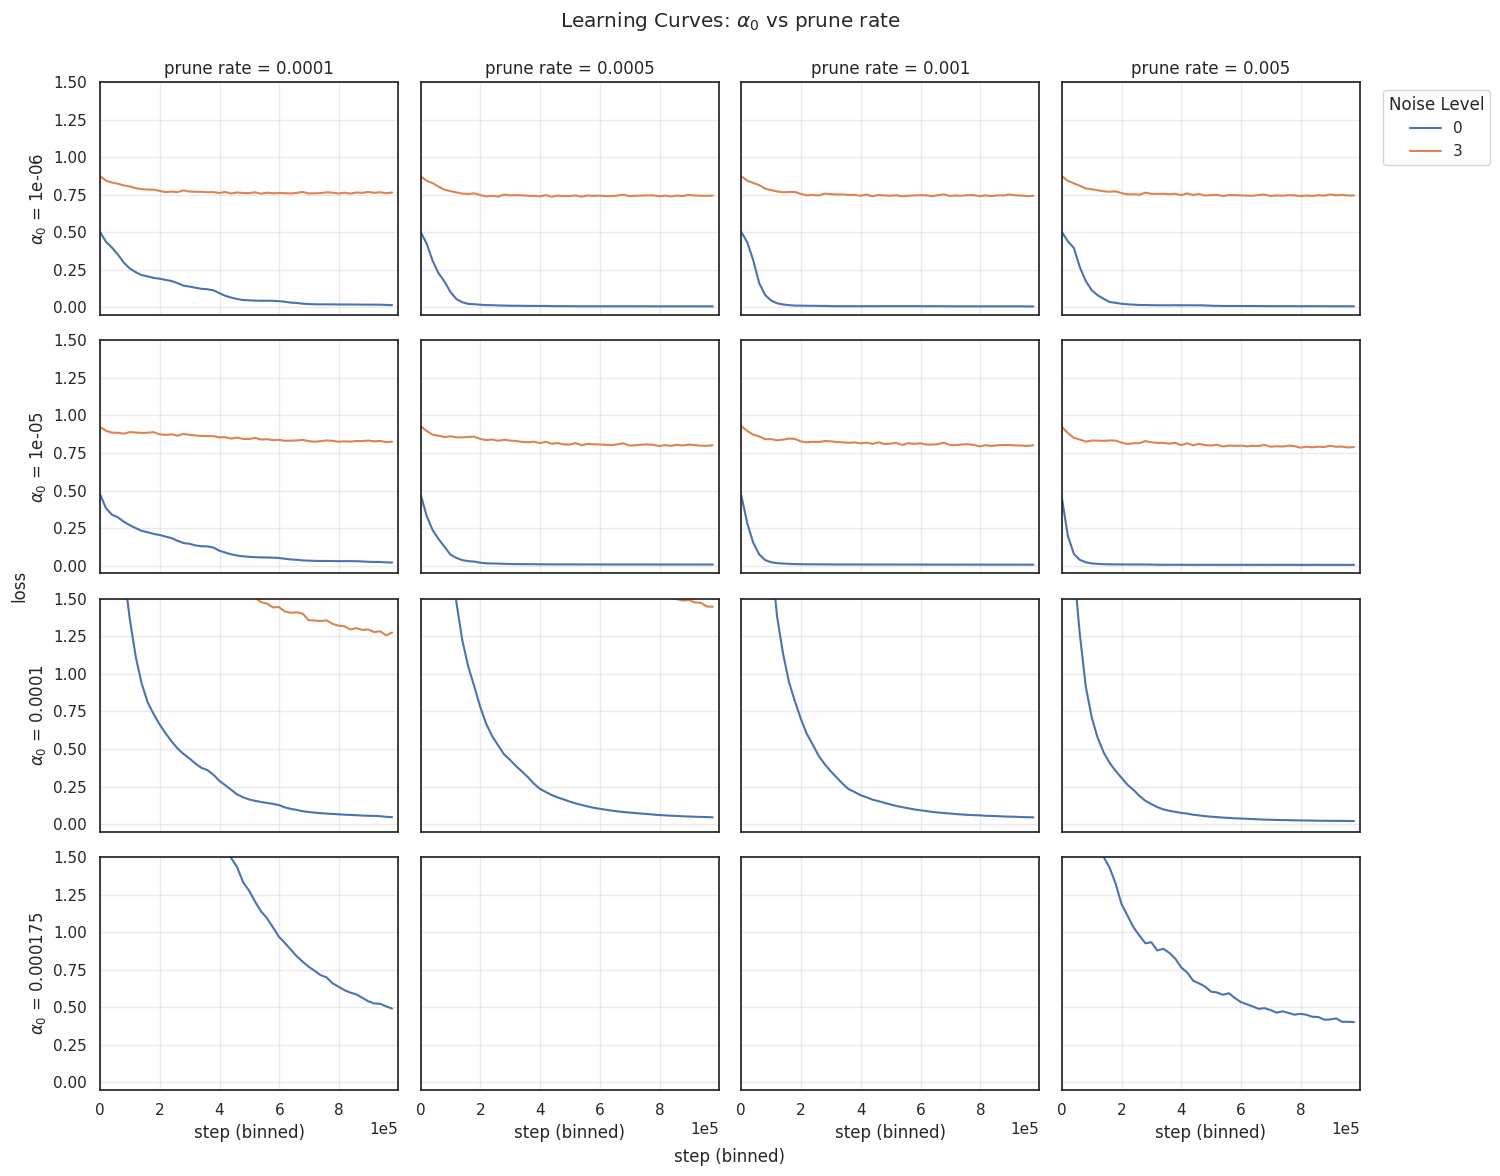

In [8]:
plot_learning_curves_grid(
    run_df = run_dfs['target_noise'],
    config_df = config_dfs['target_noise'],
    subplot_row_col = 'optimizer|learning_rate',
    subplot_col_col = 'feature_recycling|recycle_rate',
    hue_col = 'task|noise_std',
    hue_label = 'Noise Level',
    n_bins = 50,
    figsize = (15, 12),
    subplot_row_label = '$α_0$',
    subplot_col_label = 'prune rate',
    y_lim = (-0.05, 1.5),
)